Thanks to the original author - please upvote: https://www.kaggle.com/code/ahmedhaytham/rag-with-open-source-multi-modal/notebook

In [1]:
!pip install -q timm einops wikipedia chromadb open_clip_torch

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
google-cloud-pubsublite 1.8.3 requires overrides<7.0.0,>=6.0.1, but you have overrides 7.7.0 which is incompatible.
jupyterlab 4.0.10 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
kfp 2.0.1 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.0.1 requires kubernetes<27,>=8.0.0, but you have kubernetes 29.0.0 which is incompatible.
opentelemetry-exporter-otlp 1.19.0 requires opentelemetry-exporter-otlp-proto-grpc==1.19.0, b

In [2]:
!pip install -q transformers==4.36.0
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

In [3]:
import wikipedia
from tqdm import tqdm
import shutil
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import requests


import chromadb
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from chromadb.config import Settings
from chromadb.utils import embedding_functions


from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="configuration_llava.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="configuration_phi.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="modeling_llava.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="modeling_phi.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="processing_llava.py", local_dir="./", force_download=True)


from modeling_llava import LlavaForConditionalGeneration
from processing_llava import LlavaProcessor, OpenCLIPImageProcessor


from transformers import AutoTokenizer, TextStreamer


configuration_llava.py:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_llava.py:   0%|          | 0.00/11.7k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

processing_llava.py:   0%|          | 0.00/5.36k [00:00<?, ?B/s]

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

No module named 'flash_attn'
Not using Flash Attention!


In [4]:
class CFG:
    images_pth = '/kaggle/input/flowers/flowers'

# Data

In [5]:

images_classes = os.listdir(CFG.images_pth)

new_pth = 'flowers'
if not os.path.exists(new_pth):
    os.mkdir(new_pth)


for cls in tqdm(images_classes):
    cls_pth = os.path.join(CFG.images_pth, cls)
    new_cls_pth = os.path.join(new_pth, cls)
    if not os.path.exists(new_cls_pth):
        os.mkdir(new_cls_pth)
    for img in os.listdir(cls_pth)[:10]:
        img_pth = os.path.join(cls_pth, img)
        new_img_pth = os.path.join(new_cls_pth, img)
        shutil.copy(img_pth, new_img_pth)

100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


In [6]:


# secondly we will get text from wiki and save it in txt file            
wiki_titles = { # the key is imgs class and the value is wiki title
    'daisy': 'Bellis perennis',
    'dandelion': 'Taraxacum',
    'lotus': 'Nelumbo nucifera',
    'rose': 'Rose',
    'sunflower': 'Common sunflower',
    'tulip': 'Tulip',
    'bellflower':'Campanula'
}



In [7]:
# each class has 10 images and one text file content from the wiki page
for cls in tqdm(images_classes):
    cls_pth = os.path.join(new_pth, cls)
#     page_content = wikipedia.page(wiki_titles[cls], auto_suggest=False).content
    page_content = wikipedia.summary(wiki_titles[cls] ,auto_suggest=False)

    if not os.path.exists(cls_pth):
        print('Creating {} folder'.format(cls))
    else:
        #save the text file
        files_name= cls+'.txt'
        with open(os.path.join(cls_pth, files_name), 'w') as f:
            f.write(page_content)



100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


In [8]:
# this folder will contain the in very messy way
!mkdir all_data
! cp -r /kaggle/working/flowers/*/* /kaggle/working/all_data

# Vector DB

In [9]:
client = chromadb.PersistentClient(path="DB")

embedding_function = OpenCLIPEmbeddingFunction()
image_loader = ImageLoader()


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [10]:

collection_images = client.create_collection(
    name='multimodal_collection_images', 
    embedding_function=embedding_function, 
    data_loader=image_loader)

collection_text = client.create_collection(
    name='multimodal_collection_text', 
    embedding_function=embedding_function, 
    )


In [11]:
# Get the uris to the images
IMAGE_FOLDER = '/kaggle/working/all_data'

image_uris = sorted([os.path.join(IMAGE_FOLDER, image_name) for image_name in os.listdir(IMAGE_FOLDER) if not image_name.endswith('.txt')])
ids = [str(i) for i in range(len(image_uris))]

collection_images.add(ids=ids, uris=image_uris)

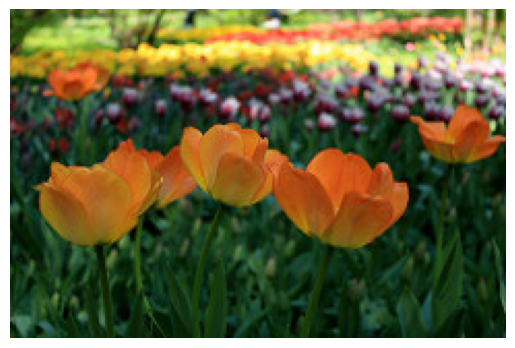

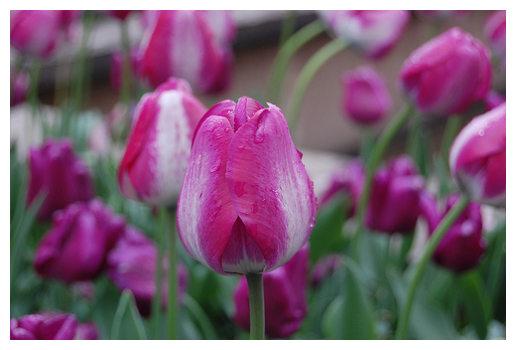

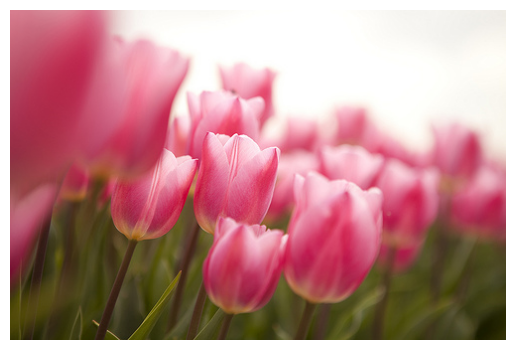

In [12]:
# sanity check

retrieved = collection_images.query(query_texts=["tulip"], include=['data'], n_results=3)
for img in retrieved['data'][0]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()



In [13]:
# now the text part
default_ef = embedding_functions.DefaultEmbeddingFunction()

text_pth = sorted([os.path.join(IMAGE_FOLDER, image_name) for image_name in os.listdir(IMAGE_FOLDER) if image_name.endswith('.txt')])

list_of_text = []
for text in text_pth:
    with open(text, 'r') as f:
        text = f.read()
        list_of_text.append(text)
        
ids_txt_list = ['id'+str(i) for i in range(len(list_of_text))]

In [14]:

collection_text.add(
    documents = list_of_text,
    ids =ids_txt_list
)


In [15]:
results = collection_text.query(
    query_texts=["What is the bellflower?"],
    n_results=1
)

results

{'ids': [['id0']],
 'distances': [[0.6072186183744086]],
 'metadatas': [[None]],
 'embeddings': None,
 'documents': [['Campanula () is the type genus of the Campanulaceae family of flowering plants. Campanula are commonly known as bellflowers and take both their common and scientific names from the bell-shaped flowers—campanula is Latin for "little bell".\nThe genus includes over 500 species and several subspecies, distributed across the temperate and subtropical regions of the Northern Hemisphere, with centers of diversity in the Mediterranean region, Balkans, Caucasus and mountains of western Asia. The range also extends into mountains in tropical regions of Asia and Africa.\nThe species include annual, biennial and perennial plants, and vary in habit from dwarf arctic and alpine species under 5 cm high, to large temperate grassland and woodland species growing to 2 metres (6 ft 7 in) tall.']],
 'uris': None,
 'data': None}

# Model

In [16]:
model = LlavaForConditionalGeneration.from_pretrained("visheratin/LLaVA-3b")
model = model.to("cuda")

tokenizer = AutoTokenizer.from_pretrained("visheratin/LLaVA-3b")

config.json:   0%|          | 0.00/3.06k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/58.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/91.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/8.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
image_processor = OpenCLIPImageProcessor(model.config.preprocess_config)
processor = LlavaProcessor(image_processor, tokenizer)

# Talk to the image

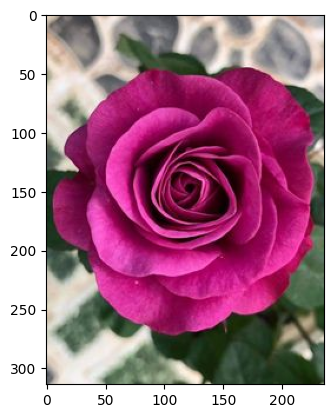

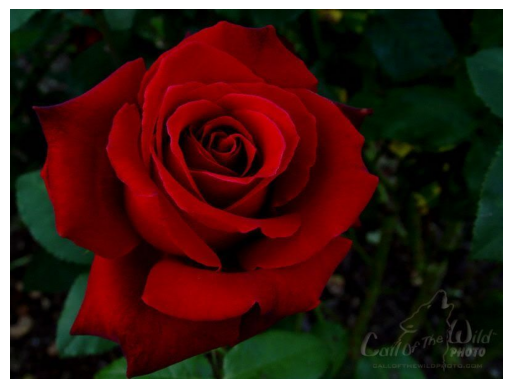

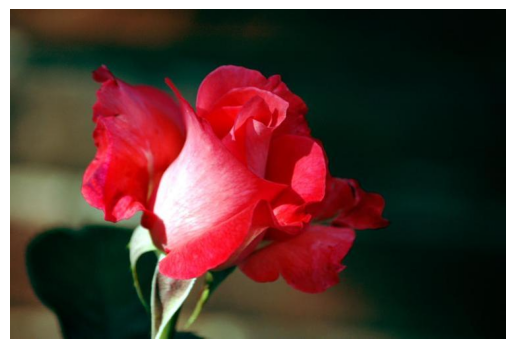

In [18]:
query_image = '/kaggle/input/flowers/flowers/rose/00f6e89a2f949f8165d5222955a5a37d.jpg'
raw_image = Image.open(query_image)

plt.imshow(raw_image)
plt.show()
imgs = collection_images.query(query_uris=query_image, include=['data'], n_results=3)
for img in imgs['data'][0][1:]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    

In [19]:
question = 'Answer with organized answers: What type of rose is in the picture? Mention some of its characteristics and how to take care of it ?'

doc = collection_text.query(
    query_embeddings=embedding_function(query_image),    
    n_results=1,
        
)['documents'][0][0]

In [20]:
doc

'A rose is either a woody perennial flowering plant of the genus Rosa (), in the family Rosaceae (), or the flower it bears. There are over three hundred species and tens of thousands of cultivars. They form a group of plants that can be erect shrubs, climbing, or trailing, with stems that are often armed with sharp prickles. Their flowers vary in size and shape and are usually large and showy, in colours ranging from white through yellows and reds. Most species are native to Asia, with smaller numbers native to Europe, North America, and northwestern Africa. Species, cultivars and hybrids are all widely grown for their beauty and often are fragrant.  Roses have acquired cultural significance in  many societies. Rose plants range in size from compact, miniature roses, to climbers that can reach seven meters in height. Different species hybridize easily, and this has been used in the development of the wide range of garden roses.'